<a href="https://colab.research.google.com/github/llukitas/Interbank_Kaggle/blob/master/g_lucas_caso_creditov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Instalacion de utilitarios Pyspark

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz


In [0]:
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


In [5]:
!pip install pyspark

     |████████████████████████████████| 215.7MB 62kB/s 
     |████████████████████████████████| 204kB 41.1MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=e8aeb86ef36fdff2a84d0db567d1948a1a1d2264b32dba508610cafa620f43b0
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [0]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local").getOrCreate()
sc = SparkContext.getOrCreate()

# 1. Lectura del origen datos

In [0]:
# Lectura desde un archivo fisico
from google.colab import files
uploaded = files.upload()

In [7]:

# Conexion al drive
#---------------------------
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
ls

drive/        spark-2.3.4-bin-hadoop2.7/     spark-2.4.4-bin-hadoop2.7/
sample_data/  spark-2.3.4-bin-hadoop2.7.tgz  spark-2.4.4-bin-hadoop2.7.tgz


#2.  Cargando los datos en formato Spark

In [9]:
credito=spark.read.csv('/content/drive/My Drive/AGRARIA_ML/Training R ML en Casos de Negocios/2_caso negocio 2 riesgo crediticio/2_DS_creditos.csv',sep=',', header=True, inferSchema=True)
# 2.1 Revisión de formatos
credito.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: string (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: string (nullable = true)



In [0]:
from pyspark.sql.types import DoubleType, IntegerType
credito = credito.withColumn("Mto_ingreso_mensual", credito["Mto_ingreso_mensual"].cast(DoubleType()))
credito = credito.withColumn("Nro_dependiente", credito["Nro_dependiente"].cast(DoubleType()))

In [11]:
credito.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: double (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: double (nullable = true)



In [12]:
# Dimensiona de base
print((credito.count(),len(credito.columns)))

(150000, 12)


In [13]:
# 2.2 Exploracion inicial
credito.describe().show()

+-------+------------------+-------------------+------------------+------------------+----------------------+----------------------+-------------------+--------------------------+-------------------+-------------------------+----------------------+------------------+
|summary|                ID|            Default|       Prct_uso_tc|              Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda| Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|   Nro_dependiente|
+-------+------------------+-------------------+------------------+------------------+----------------------+----------------------+-------------------+--------------------------+-------------------+-------------------------+----------------------+------------------+
|  count|            150000|             150000|            150000|            150000|                150000|                150000|             120269|                    150000|             1500

In [14]:
# 2.3 Proceso para identificar valores nulos en cada variables
from pyspark.sql.functions import col,sum
credito.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in credito.columns)).show()
credito.select(*(sum(col(c).isNull().cast("int")/150000).alias(c) for c in credito.columns)).show()

+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
| ID|Default|Prct_uso_tc|Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda|Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|Nro_dependiente|
+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
|  0|      0|          0|   0|                     0|                     0|              29731|                         0|                 0|                        0|                     0|           3924|
+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+

#3.  Imputacion  de datos
Se identifico que hay 2 columnas con valores nulos o vacios:

Nro_dependiente   -->    2.6% nulos imputamos valores

 Mto_ingreso_mensual  -->      19.87% nulos imputamos valores

In [15]:
#2.4 Variable objetivo
print(credito.count())
credito.groupBy('Nro_dependiente').count().show(1000)

150000
+---------------+-----+
|Nro_dependiente|count|
+---------------+-----+
|            8.0|   24|
|            0.0|86902|
|            7.0|   51|
|           null| 3924|
|            1.0|26316|
|            4.0| 2862|
|            3.0| 9483|
|            2.0|19522|
|           10.0|    5|
|           13.0|    1|
|            6.0|  158|
|           20.0|    1|
|            5.0|  746|
|            9.0|    5|
+---------------+-----+



In [16]:
#credito.stat.approxQuantile("Nro_dependiente", Array(0.5), 0.25)
credito.approxQuantile("Mto_ingreso_mensual", [0.5], 0.25)

[5400.0]

In [17]:
# imputacion por mediana
from pyspark.ml.feature import Imputer 
credito.show (5)
imputer = Imputer (inputCols = ["Mto_ingreso_mensual", "Nro_dependiente"], outputCols = ["Mto_ingreso_mensual", "Nro_dependiente"]) 
model = imputer.setStrategy("median").fit (credito) 
credito = model.transform (credito) 
credito.show (5)


+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
| ID|Default|Prct_uso_tc|Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda|Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|Nro_dependiente|
+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
|  1|      1|0.766126609|  45|                     2|           0.802982129|             9120.0|                        13|                 0|                        6|                     0|            2.0|
|  2|      0|0.957151019|  40|                     0|           0.121876201|             2600.0|                         4|                 0|                        0|

In [18]:
#2.4 Variable objetivo
print(credito.count())
credito.groupBy('Default').count().show()
# Efectividad de venta
(10026/150000)*100

150000
+-------+------+
|Default| count|
+-------+------+
|      1| 10026|
|      0|139974|
+-------+------+



6.683999999999999

# Informacion Value

In [19]:
!pip install scorecardpy

     |████████████████████████████████| 61kB 4.5MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.1.1-cp36-none-any.whl size=58169 sha256=c552bdc661fac36d232a791c743e8c142bf1e10c79fb4211591b377ba6a20af2
  Stored in directory: /root/.cache/pip/wheels/8f/4c/98/567ff70984acd88ffae211d8fc209e34b98fb43ff27f09fdd3
Successfully built scorecardpy


In [0]:
import scorecardpy as sc
import pandas as pd

In [21]:
type(credito)

pyspark.sql.dataframe.DataFrame

In [22]:
df = credito.toPandas()
type(df)

pandas.core.frame.DataFrame

In [0]:
df.drop(['ID'], axis='columns', inplace=True)

In [24]:
df.head()

,Default,Prct_uso_tc,Edad,Nro_prestao_retrasados,Prct_deuda_vs_ingresos,Mto_ingreso_mensual,Nro_prod_financieros_deuda,Nro_retraso_60dias,Nro_creditos_hipotecarios,Nro_retraso_ultm3anios,Nro_dependiente
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [25]:
# Formato de variables ScorecardPy
dt_s = sc.var_filter(df, y="Default")

[INFO] filtering variables ...
Variable filtering on 150000 rows and 11 columns in 00:04:11 
0 variables are removed


In [26]:
bins = sc.woebin(dt_s, y="Default")

[INFO] creating woe binning ...
Binning on 150000 rows and 11 columns in 00:00:12


In [27]:
# De acuerdo al analisis de correlacion de Spearman o Information Value
# Las variables m;as relevantes son: Nro_retraso_60dias, Mto_ingreso_mensual, Nro_prestao_retrasados
sc.iv(dt_s, y="Default")

,variable,info_value
3,Nro_retraso_60dias,0.881208
6,Mto_ingreso_mensual,0.836594
0,Nro_prestao_retrasados,0.761158
2,Nro_retraso_ultm3anios,0.601024
4,Prct_deuda_vs_ingresos,0.406449
1,Prct_uso_tc,0.307700
7,Edad,0.274367
9,Nro_prod_financieros_deuda,0.116379
8,Nro_creditos_hipotecarios,0.068348
5,Nro_dependiente,0.035484


{'Edad': <Figure size 432x288 with 2 Axes>,
 'Mto_ingreso_mensual': <Figure size 432x288 with 2 Axes>,
 'Nro_creditos_hipotecarios': <Figure size 432x288 with 2 Axes>,
 'Nro_dependiente': <Figure size 432x288 with 2 Axes>,
 'Nro_prestao_retrasados': <Figure size 432x288 with 2 Axes>,
 'Nro_prod_financieros_deuda': <Figure size 432x288 with 2 Axes>,
 'Nro_retraso_60dias': <Figure size 432x288 with 2 Axes>,
 'Nro_retraso_ultm3anios': <Figure size 432x288 with 2 Axes>,
 'Prct_deuda_vs_ingresos': <Figure size 432x288 with 2 Axes>,
 'Prct_uso_tc': <Figure size 432x288 with 2 Axes>}

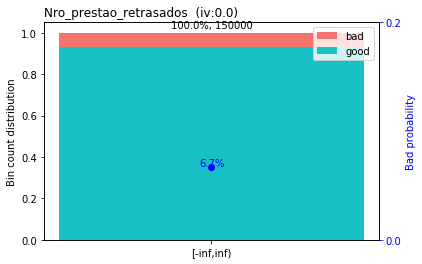

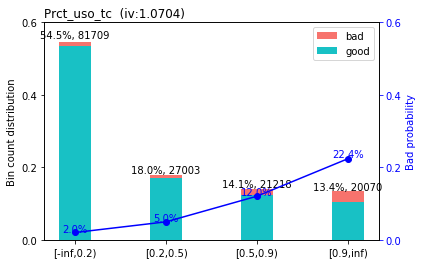

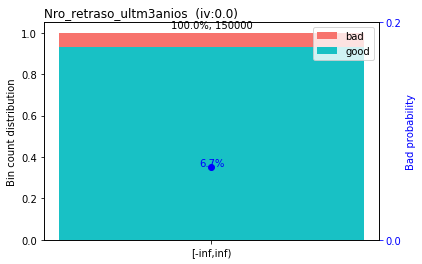

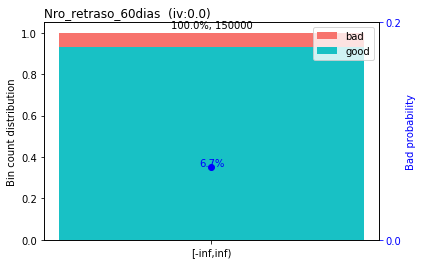

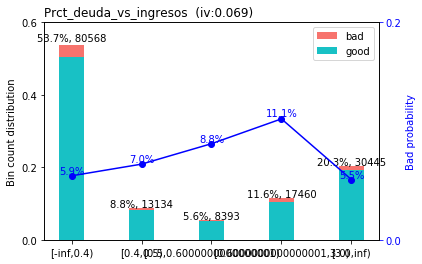

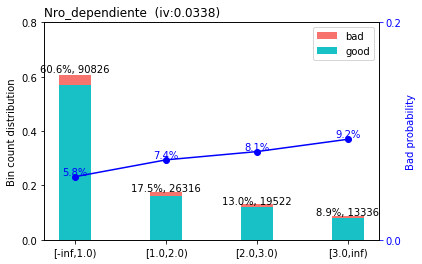

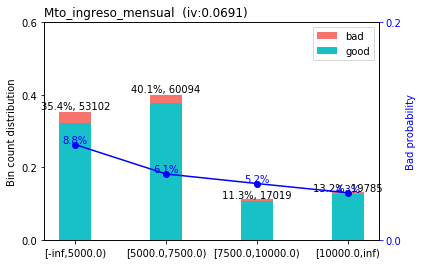

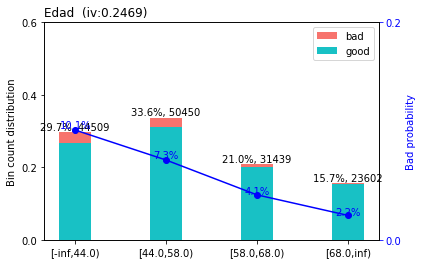

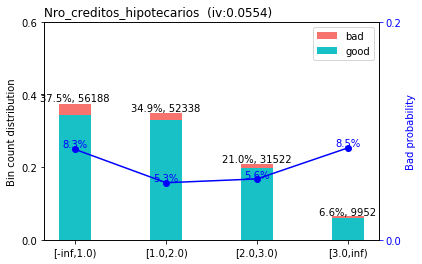

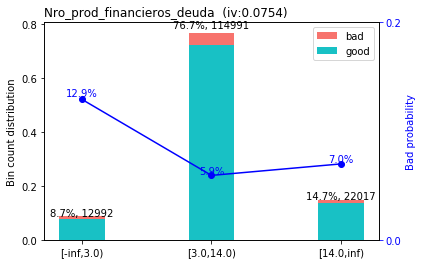

In [28]:
# graficando los Insight identificados
#bins = sc.woebin(dt_s[['Nro_retraso_60dias','Mto_ingreso_mensual','Nro_prestao_retrasados','Nro_retraso_ultm3anios','Prct_deuda_vs_ingresos']], y="Default")
sc.woebin_plot(bins)

In [34]:
credito.printSchema()


root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: double (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: double (nullable = true)



In [0]:
import pandas as pd
from pandas.plotting import scatter_matrix

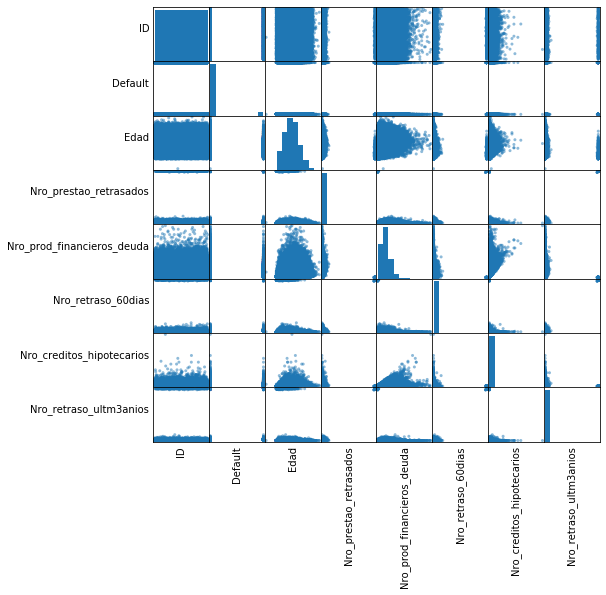

In [41]:
numeric_features = [t[0] for t in credito.dtypes if t[1] == 'int']
numeric_data = credito.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

#3.  Preparando la información para el modelamiento

In [0]:
# REdefiniendo feature
# Se elimina en caso ya exista una nueva columna
credito=credito.drop("features")

In [0]:
# Creando las variables nevesarias para el modelamiento
# ESCENARIO 1 -- NO USADO
# Consolidacion de variables
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.feature import VectorAssembler  
# Transformacion
df_assembler = VectorAssembler(inputCols=['Nro_retraso_60dias','Mto_ingreso_mensual','Nro_prestao_retrasados','Nro_retraso_ultm3anios','Nro_dependiente','Prct_uso_tc'], outputCol="features")
credito = df_assembler.transform(credito)

In [147]:
#Revision
#DS_Renovacion_prest.printSchema()
credito.select('Default','features').show(3,False)

+-------+------------------------------------+
|Default|features                            |
+-------+------------------------------------+
|1      |[0.0,9120.0,2.0,0.0,2.0,0.766126609]|
|0      |[0.0,2600.0,0.0,0.0,1.0,0.957151019]|
|0      |[1.0,3042.0,1.0,0.0,0.0,0.65818014] |
+-------+------------------------------------+
only showing top 3 rows



In [0]:
#Matriz de Modelamiento
model_df_credito_t=credito.select('Default','features')

In [149]:
model_df_credito_t.printSchema()

root
 |-- Default: integer (nullable = true)
 |-- features: vector (nullable = true)



# 5.  Seleccionando la muestra de aprendizaje y validacion


In [150]:
# Definicion de muestra de entrenamiento y Validacion

training_df,test_df=model_df_credito_t.randomSplit([0.5,0.5],seed=1234) 

# Tamaño de muestra
print(training_df.count(),test_df.count())

75059 74941


#6.  Modelamiento de predictivo

In [0]:
# Modelamiento de Regresion Logistica
from pyspark.ml.classification import LogisticRegression
log_reg=LogisticRegression(featuresCol='features',labelCol='Default', maxIter=10).fit(training_df)

In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Default', maxIter=10)
lrModel = lr.fit(training_df)
## Tamaño de muestra
#print(training_df.count(),test_df.count())

In [163]:
# Revision
log_reg.coefficients

DenseVector([0.1385, -0.0001, 0.4528, -0.5499, 0.2712, -0.0002])

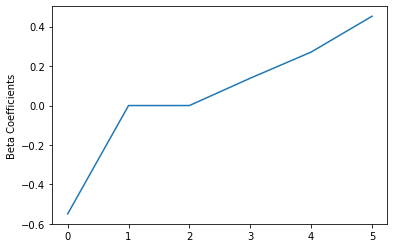

In [164]:
# Representacion grafica de los betas de la REgresion Logistica
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(log_reg.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

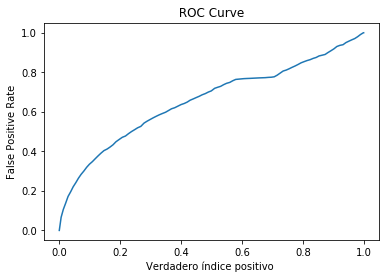

 Training set areaUnderROC: 0.6567441882312169


In [165]:
trainingSummary = log_reg.summary 
roc = trainingSummary.roc.toPandas () 
plt.plot (roc ['FPR'], roc ['TPR']) 
plt.ylabel ('False Positive Rate') 
plt.xlabel ('Verdadero índice positivo ') 
plt.title (' ROC Curve ') 
plt.show () 
print (' Training set areaUnderROC: '+ str (trainingSummary.areaUnderROC))

In [166]:
# Aplicando sobre la data Train el modelo identificado

train_results=log_reg.evaluate(training_df).predictions

# Verificando las probabilidad en los clientes con compra

train_results.filter(train_results['Default']==1).select(['Default','prediction','probability']).show(10,False)

+-------+----------+----------------------------------------+
|Default|prediction|probability                             |
+-------+----------+----------------------------------------+
|1      |0.0       |[0.9038787824124922,0.0961212175875078] |
|1      |0.0       |[0.9189553937736479,0.08104460622635215]|
|1      |0.0       |[0.939355158385091,0.06064484161490897] |
|1      |0.0       |[0.948574926409798,0.05142507359020208] |
|1      |0.0       |[0.92250248290133,0.07749751709866994]  |
|1      |0.0       |[0.8600768048274002,0.13992319517259982]|
|1      |0.0       |[0.8911686510125272,0.10883134898747283]|
|1      |0.0       |[0.9235472401392675,0.07645275986073254]|
|1      |0.0       |[0.9235736648067729,0.07642633519322706]|
|1      |0.0       |[0.9261741789345151,0.07382582106548491]|
+-------+----------+----------------------------------------+
only showing top 10 rows



# 7. Evaluacion del modelo


In [0]:
# Aplicando el modelo predictivo
transformed = log_reg.transform(test_df)

In [168]:
test_df.show(5)

+-------+---------+
|Default| features|
+-------+---------+
|      0|(6,[],[])|
|      0|(6,[],[])|
|      0|(6,[],[])|
|      0|(6,[],[])|
|      0|(6,[],[])|
+-------+---------+
only showing top 5 rows



In [169]:
# Revision
transformed.show(3,False)

+-------+---------+----------------------------------------+---------------------------------------+----------+
|Default|features |rawPrediction                           |probability                            |prediction|
+-------+---------+----------------------------------------+---------------------------------------+----------+
|0      |(6,[],[])|[2.3796316032906133,-2.3796316032906133]|[0.915260866375843,0.08473913362415701]|0.0       |
|0      |(6,[],[])|[2.3796316032906133,-2.3796316032906133]|[0.915260866375843,0.08473913362415701]|0.0       |
|0      |(6,[],[])|[2.3796316032906133,-2.3796316032906133]|[0.915260866375843,0.08473913362415701]|0.0       |
+-------+---------+----------------------------------------+---------------------------------------+----------+
only showing top 3 rows



In [170]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='Default')
print('Test Area Under ROC', evaluator.evaluate(transformed))

Test Area Under ROC 0.6630493309114256
